<a href="https://colab.research.google.com/github/Ybtry/Birhan-Energies-/blob/Task-2-Point-Modeling-and-Insight-Generation/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data has been cleaned. Number of data points for modeling: 9010
Success: The 'y' array is clean and ready for the model.


Output()

                                       Accept                Step       Grad       Sampling                       
  Progress   Draws   Tuning   Scaling   Rate       Diverge…   size       evals      Speed      Elapsed   Remaini…  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━   3000    False    29.28     1.00       0          1.14       3          251.49     0:00:11   0:00:00   
                                                                                    draws/s                        
  ━╺━━━━━━   513     True     22.00     1.14       0          1.09       3          31.54      0:00:16   0:00:22   
                                                                                    draws/s

Sampling complete. The idata object contains the posterior distributions.

--- Summary of Model Parameters ---
             mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      5387.888  21.349  5347.000  5420.000      0.943    0.675     544.0   
mu_1        0.000   0.000    -0.000     0.001      0.000    0.000    6919.0   
mu_2       -0.000   0.000    -0.001     0.001      0.000    0.000    8015.0   
sigma_1     0.023   0.000     0.023     0.023      0.000    0.000    7622.0   
sigma_2     0.029   0.000     0.028     0.030      0.000    0.000    6752.0   

         ess_tail  r_hat  
tau         679.0    1.0  
mu_1       3129.0    1.0  
mu_2       2949.0    1.0  
sigma_1    3245.0    1.0  
sigma_2    2707.0    1.0  

Most likely change point index: 5387
Most likely change point date: 2008-07-25


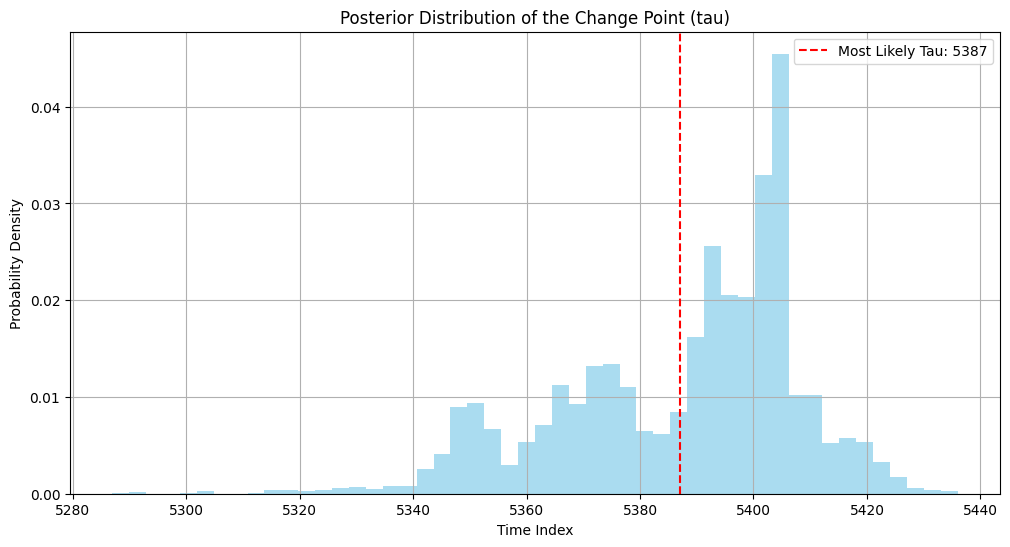

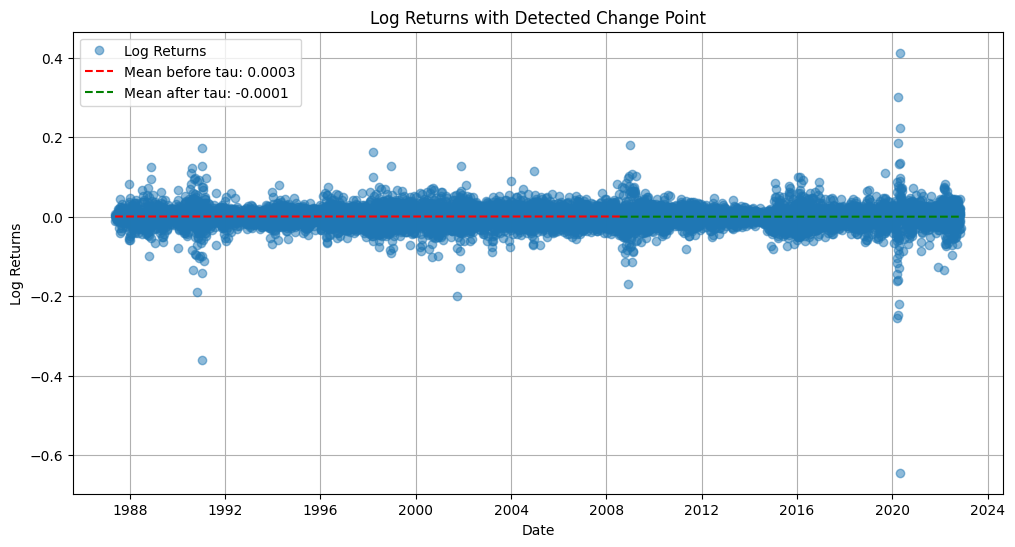


--- Performing Model Comparison ---
Comparing the Change Point Model to a Null Model (no change point).


Output()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━╸━━━━━━━━━━━━━━━━   1051    0             1.49        3            673.00 draws/s   0:00:01   0:00:03    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   0       0             0.00        0            0.00 draws/s     0:00:01   -:--:--


--- Model Comparison Summary (using WAIC and LOO) ---


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


                    rank     elpd_waic     p_waic   elpd_diff    weight  \
change_point_model     0  20340.933486  60.701622    0.000000  0.497884   
null_model             1  20240.520861  35.185795  100.412625  0.502116   

                            se        dse  warning scale  
change_point_model  347.011901   0.000000     True   log  
null_model          404.270127  81.651073     True   log  




/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


                    rank      elpd_loo      p_loo   elpd_diff    weight  \
change_point_model     0  20347.132145  54.502963    0.000000  0.497673   
null_model             1  20245.968171  29.738486  101.163974  0.502327   

                            se        dse  warning scale  
change_point_model  342.149763   0.000000     True   log  
null_model          399.946562  82.460441     True   log  


In [10]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

file_path = 'BrentOilPrices.csv'
df = pd.read_csv(file_path)

df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Price'])

df['Log_Returns'] = np.log(df['Price']).diff()
clean_df = df.dropna(subset=['Log_Returns'])

y = clean_df['Log_Returns'].values
n_points = len(y)
dates = clean_df.index.values

print(f"Data has been cleaned. Number of data points for modeling: {n_points}")
if np.isnan(y).any():
    print("Warning: The 'y' array still contains NaN values. Please check your data cleaning.")
else:
    print("Success: The 'y' array is clean and ready for the model.")

y_std = np.std(y)
y_mean = np.mean(y)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_points - 1)
    mu_1 = pm.Normal("mu_1", mu=y_mean, sigma=y_std*5)
    mu_2 = pm.Normal("mu_2", mu=y_mean, sigma=y_std*5)
    sigma_1 = pm.HalfNormal("sigma_1", sigma=y_std*5)
    sigma_2 = pm.HalfNormal("sigma_2", sigma=y_std*5)
    mu = pm.math.switch(tau > np.arange(n_points), mu_1, mu_2)
    sigma = pm.math.switch(tau > np.arange(n_points), sigma_1, sigma_2)
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)
    idata = pm.sample(draws=2000, tune=1000, chains=2, cores=1, init='auto', idata_kwargs={'log_likelihood': True})

print("Sampling complete. The idata object contains the posterior distributions.")

print("\n--- Summary of Model Parameters ---")
print(az.summary(idata, var_names=["tau", "mu_1", "mu_2", "sigma_1", "sigma_2"]))

tau_posterior = idata.posterior["tau"].values.flatten()
most_likely_tau = int(np.mean(tau_posterior))
most_likely_date = dates[most_likely_tau]

print(f"\nMost likely change point index: {most_likely_tau}")
print(f"Most likely change point date: {pd.to_datetime(most_likely_date).strftime('%Y-%m-%d')}")

plt.figure(figsize=(12, 6))
plt.hist(tau_posterior, bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Posterior Distribution of the Change Point (tau)')
plt.xlabel('Time Index')
plt.ylabel('Probability Density')
plt.axvline(most_likely_tau, color='red', linestyle='--', label=f'Most Likely Tau: {most_likely_tau}')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, y, 'o', label='Log Returns', alpha=0.5)
plt.title('Log Returns with Detected Change Point')
plt.xlabel('Date')
plt.ylabel('Log Returns')

mu_1_mean = idata.posterior["mu_1"].values.mean()
mu_2_mean = idata.posterior["mu_2"].values.mean()

plt.plot(dates[:most_likely_tau], [mu_1_mean] * most_likely_tau, 'r--', label=f'Mean before tau: {mu_1_mean:.4f}')
plt.plot(dates[most_likely_tau:], [mu_2_mean] * (n_points - most_likely_tau), 'g--', label=f'Mean after tau: {mu_2_mean:.4f}')

plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------------------------------------
# --- NEW CODE FOR OPTIONAL TASK 2.2: MODEL COMPARISON ---
# --------------------------------------------------------------------------------------
print("\n--- Performing Model Comparison ---")
print("Comparing the Change Point Model to a Null Model (no change point).")

# Define the Null Model (assuming no change point)
with pm.Model() as null_model:
    # Priors for a single mean and standard deviation for the entire dataset
    mu_null = pm.Normal("mu_null", mu=y_mean, sigma=y_std * 5)
    sigma_null = pm.HalfNormal("sigma_null", sigma=y_std * 5)

    # Likelihood for the null model
    likelihood_null = pm.Normal("likelihood_null", mu=mu_null, sigma=sigma_null, observed=y)

    # Sample from the null model
    idata_null = pm.sample(draws=2000, tune=1000, chains=2, cores=1, init='auto', idata_kwargs={'log_likelihood': True})

# Compare the two models using ArviZ's compare function
print("\n--- Model Comparison Summary (using WAIC and LOO) ---")
df_comp = az.compare({"change_point_model": idata, "null_model": idata_null}, ic="waic", scale="log")
print(df_comp)

print("\n")

df_comp = az.compare({"change_point_model": idata, "null_model": idata_null}, ic="loo", scale="log")
print(df_comp)
